In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import glob

from dask.distributed import Client

In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37863,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33237,Total threads: 1
Dashboard: /proxy/41937/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:42273,


In [3]:
base = '/g/data/ik11/outputs/'
# IAF runs:
runs = {'JRA55 IAF 1-deg':{'base':base+'access-om2/1deg_jra55_iaf_era5comparison','color':'C0','chunks':{'grid_yu_ocean':100}},
        'ERA5 IAF 1-deg':{'base':base+'access-om2/1deg_era5_iaf','color':'C1','chunks':{'grid_yu_ocean':100}},
        'JRA55 IAF 025-deg':{'base':base+'access-om2-025/025deg_jra55_iaf_era5comparison','color':'C2','chunks':{'grid_yu_ocean':108}},
        'ERA5 IAF 025-deg':{'base':base+'access-om2-025/025deg_era5_iaf','color':'C3','chunks':{'grid_yu_ocean':108}}
       }

## Date range for each experiment

In [20]:
for ekey in runs.keys():
    ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-scalar*.nc')))
    start = ds.time.isel(time=0)
    end = ds.time.isel(time=-1)
    print(ekey + ' ' + str(start.values)[:10] + ' to ' + str(end.values)[:10])

JRA55 IAF 1-deg 1959-01-02 to 2020-01-01
ERA5 IAF 1-deg 1960-01-02 to 2019-01-01
JRA55 IAF 025-deg 1980-01-02 to 2020-01-01
ERA5 IAF 025-deg 1980-01-02 to 2023-04-01


## Scalar diagnostics

In [24]:
def plot_timeseries(variable,keys=runs.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-scalar*.nc')))
        var = ds[variable].resample(time='1M').mean()
        var.plot(label=ekey,color=runs[ekey]['color'])
    plt.xlabel('Time (years)')
    plt.legend()
    return

Text(0.5, 1.0, 'Total Kinetic Energy')

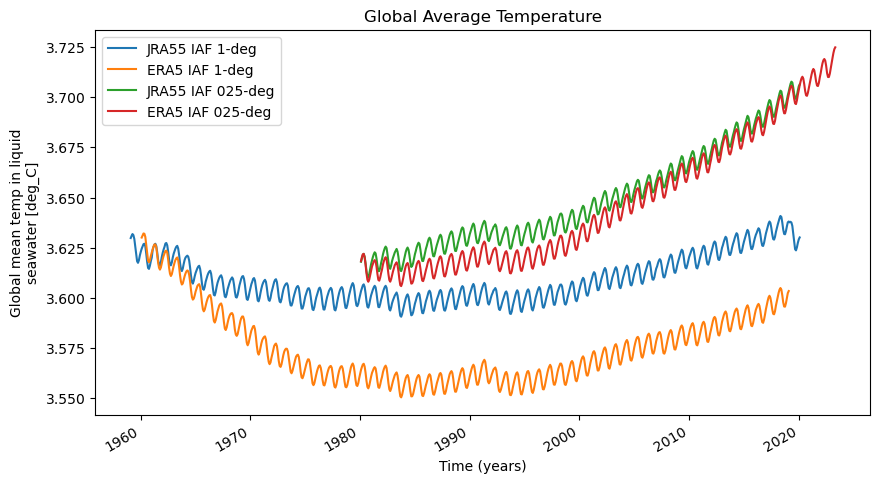

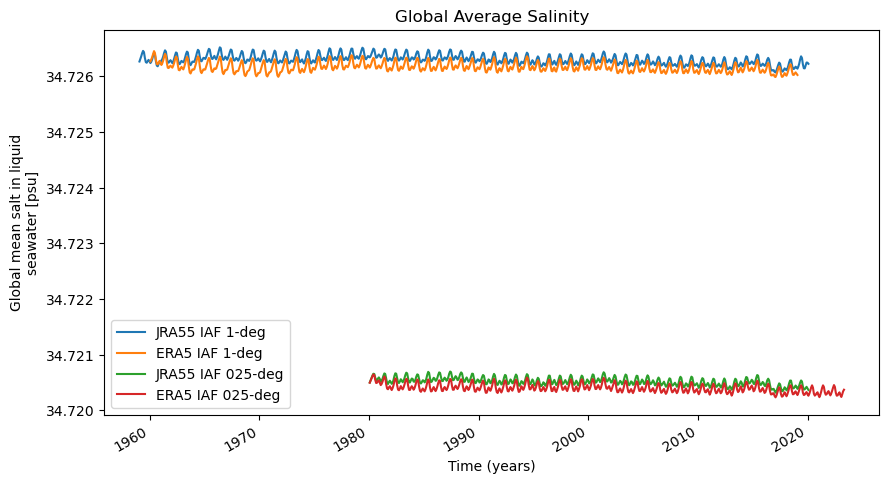

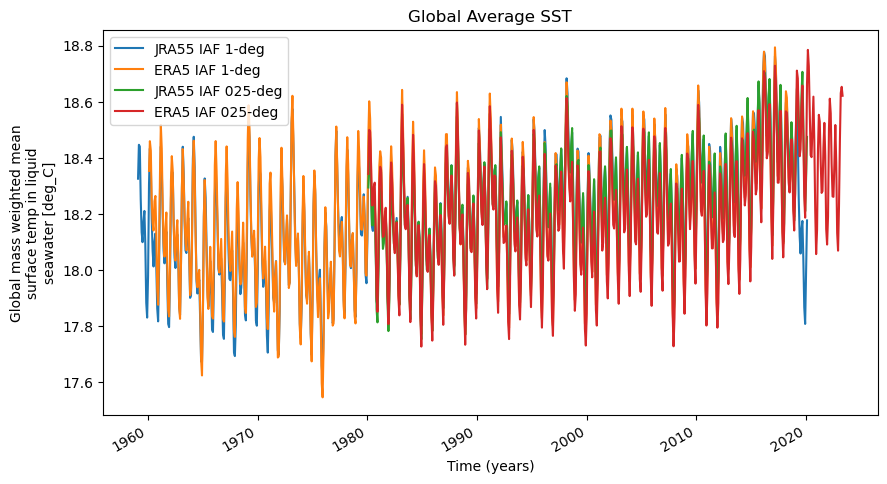

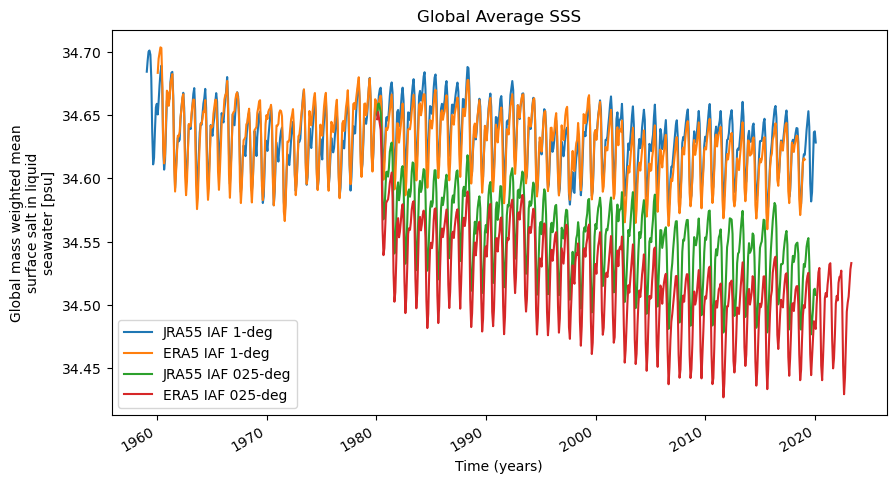

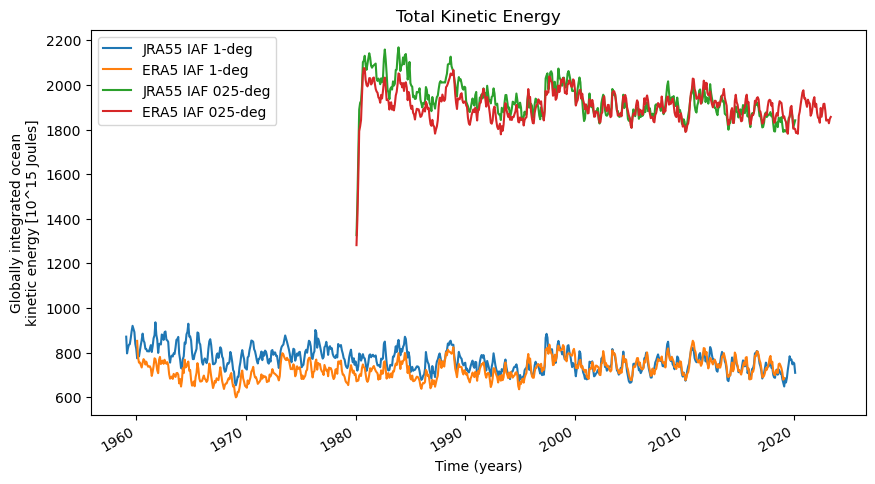

In [26]:
plot_timeseries('temp_global_ave')
plt.title('Global Average Temperature')
plot_timeseries('salt_global_ave')
plt.title('Global Average Salinity')
plot_timeseries('temp_surface_ave')
plt.title('Global Average SST')
plot_timeseries('salt_surface_ave')
plt.title('Global Average SSS')
plot_timeseries('ke_tot')
plt.title('Total Kinetic Energy')

## Circulation Diagnostics

### Drake Passage Transport

JRA55 IAF 1-deg
ERA5 IAF 1-deg
JRA55 IAF 025-deg
ERA5 IAF 025-deg
CPU times: user 18 s, sys: 5.58 s, total: 23.6 s
Wall time: 22.2 s


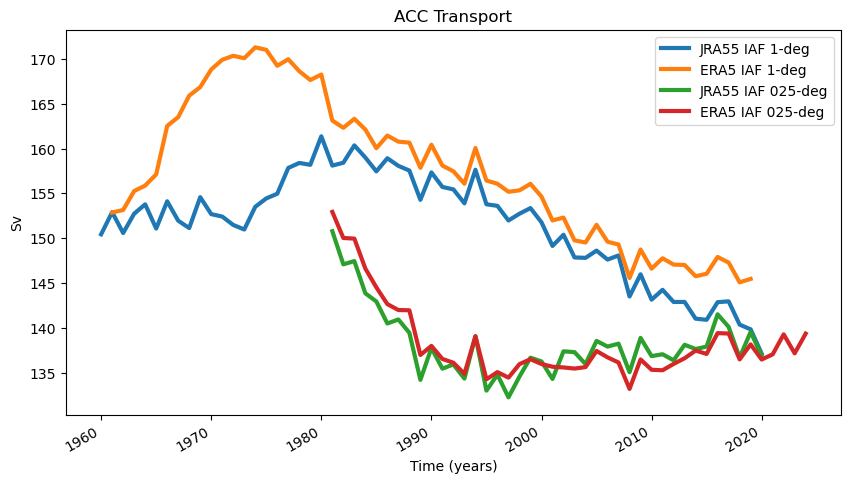

In [31]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in runs.keys():
    print(ekey)
    ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-2d-tx_trans_int_z-1-monthly-mean*.nc')))
    var = ds[variable]
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
    DP.resample(time='Y').mean().plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
plt.title("ACC Transport")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.legend()

### AMOC Overturning in density space @ 26°N

Doing JRA55 IAF 1-deg year 000 of 061
Doing JRA55 IAF 1-deg year 010 of 061
Doing JRA55 IAF 1-deg year 020 of 061
Doing JRA55 IAF 1-deg year 030 of 061
Doing JRA55 IAF 1-deg year 040 of 061
Doing JRA55 IAF 1-deg year 050 of 061
Doing ERA5 IAF 1-deg year 000 of 059
Doing ERA5 IAF 1-deg year 010 of 059
Doing ERA5 IAF 1-deg year 020 of 059
Doing ERA5 IAF 1-deg year 030 of 059
Doing ERA5 IAF 1-deg year 040 of 059
Doing ERA5 IAF 1-deg year 050 of 059
Doing JRA55 IAF 025-deg year 000 of 040
Doing JRA55 IAF 025-deg year 010 of 040


2023-07-31 11:51:18,572 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Doing JRA55 IAF 025-deg year 020 of 040
Doing JRA55 IAF 025-deg year 030 of 040
Doing ERA5 IAF 025-deg year 000 of 044
Doing ERA5 IAF 025-deg year 010 of 044
Doing ERA5 IAF 025-deg year 020 of 044
Doing ERA5 IAF 025-deg year 030 of 044
Doing ERA5 IAF 025-deg year 040 of 044
CPU times: user 2min 30s, sys: 23.7 s, total: 2min 54s
Wall time: 7min 58s


Text(0.5, 1.0, 'AMOC (rho) at 26N')

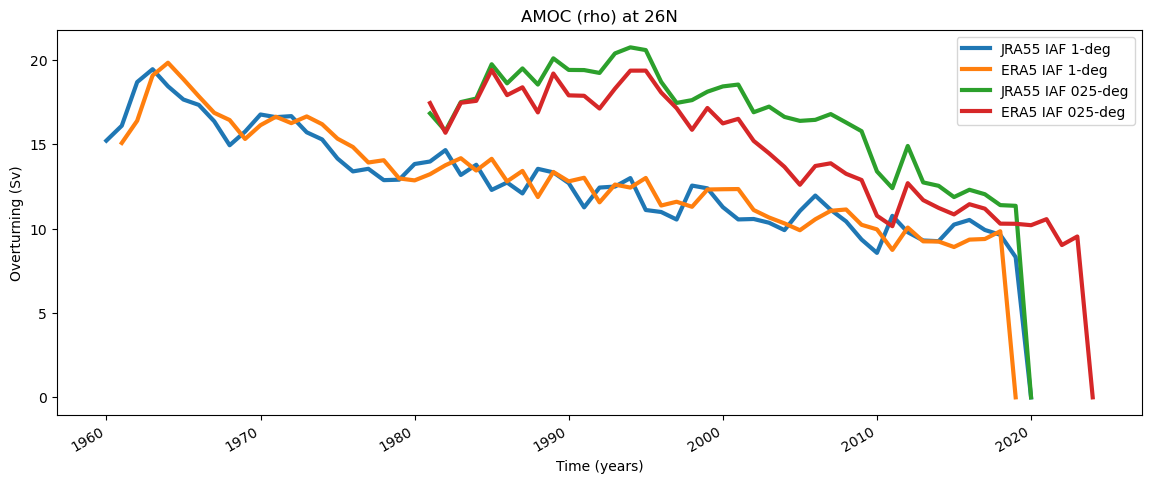

In [25]:
%%time
latitude=26.
plt.figure(figsize=(14,5))
for ekey in runs.keys():
    ds1 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])
    ds2 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])

    var_out = xr.zeros_like(ds1.time.resample(time='Y').mean()).astype('float')
    for i in range(len(var_out.time)-1):
        if ((i % 10) == 0):
            print('Doing ' + ekey + ' year %03d of %03d' % (i,len(var_out.time)))
        ds1_year = ds1.isel(time=slice(i*12,(i+1)*12))
        ds2_year = ds2.isel(time=slice(i*12,(i+1)*12))
        psi_amoc = ds1_year['ty_trans_rho'].sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
        psi_amoc_gm = ds2_year['ty_trans_rho_gm'].sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
        psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
        var_out[i] = psi_amoc_sum.mean('time').values
    var_out.plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 26N')

### AABW overturning circulation @ 55°S

Doing JRA55 IAF 1-deg year 000 of 061
Doing JRA55 IAF 1-deg year 010 of 061
Doing JRA55 IAF 1-deg year 020 of 061
Doing JRA55 IAF 1-deg year 030 of 061
Doing JRA55 IAF 1-deg year 040 of 061
Doing JRA55 IAF 1-deg year 050 of 061
Doing ERA5 IAF 1-deg year 000 of 059
Doing ERA5 IAF 1-deg year 010 of 059
Doing ERA5 IAF 1-deg year 020 of 059
Doing ERA5 IAF 1-deg year 030 of 059
Doing ERA5 IAF 1-deg year 040 of 059
Doing ERA5 IAF 1-deg year 050 of 059
Doing JRA55 IAF 025-deg year 000 of 040
Doing JRA55 IAF 025-deg year 010 of 040
Doing JRA55 IAF 025-deg year 020 of 040
Doing JRA55 IAF 025-deg year 030 of 040
Doing ERA5 IAF 025-deg year 000 of 044
Doing ERA5 IAF 025-deg year 010 of 044
Doing ERA5 IAF 025-deg year 020 of 044
Doing ERA5 IAF 025-deg year 030 of 044
Doing ERA5 IAF 025-deg year 040 of 044
CPU times: user 3min 51s, sys: 36.1 s, total: 4min 27s
Wall time: 13min 30s


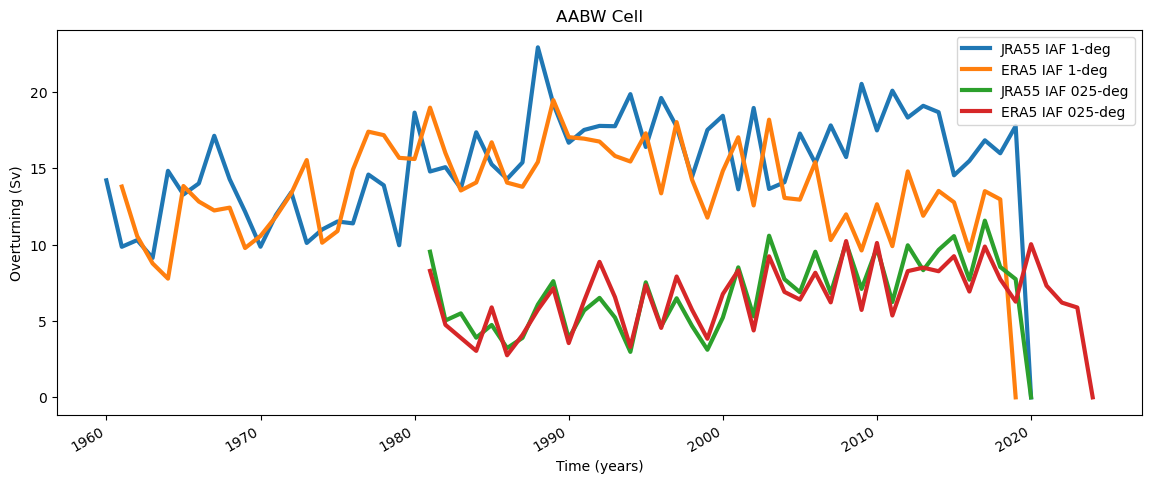

In [35]:
%%time
latitude=-55
plt.figure(figsize=(14,5))
for ekey in runs.keys():
    ds1 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])
    ds2 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])

    var_out = xr.zeros_like(ds1.time.resample(time='Y').mean()).astype('float')
    for i in range(len(var_out.time)-1):
        if ((i % 10) == 0):
            print('Doing ' + ekey + ' year %03d of %03d' % (i,len(var_out.time)))
        ds1_year = ds1.isel(time=slice(i*12,(i+1)*12))
        ds2_year = ds2.isel(time=slice(i*12,(i+1)*12))
        psi_aabw = ds1_year['ty_trans_rho'].sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
        psi_aabw_gm = ds2_year['ty_trans_rho_gm'].sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
        psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
        var_out[i] = psi_aabw_sum.mean('time').values
    var_out.plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

### Ice Area (in both hemispheres)

JRA55 IAF 1-deg


2023-07-31 11:35:01,547 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-07-31 11:35:03,886 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-07-31 11:35:06,565 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-07-31 11:35:09,653 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-07-31 11:35:13,073 - distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
2023-07-31 11:35:17,035 - distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
2023-07-31 11:35:29,511 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)


ERA5 IAF 1-deg


2023-07-31 11:35:40,890 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:35:48,020 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:35:51,297 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:35:54,890 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:35:59,213 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:36:06,133 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)


JRA55 IAF 025-deg


2023-07-31 11:36:28,273 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:36:31,252 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:36:34,651 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:36:40,088 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)


ERA5 IAF 025-deg


2023-07-31 11:36:59,319 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:37:01,552 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:37:04,148 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:37:07,038 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:37:10,415 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-07-31 11:37:27,507 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Text(0.5, 1.0, 'Southern Ocean')

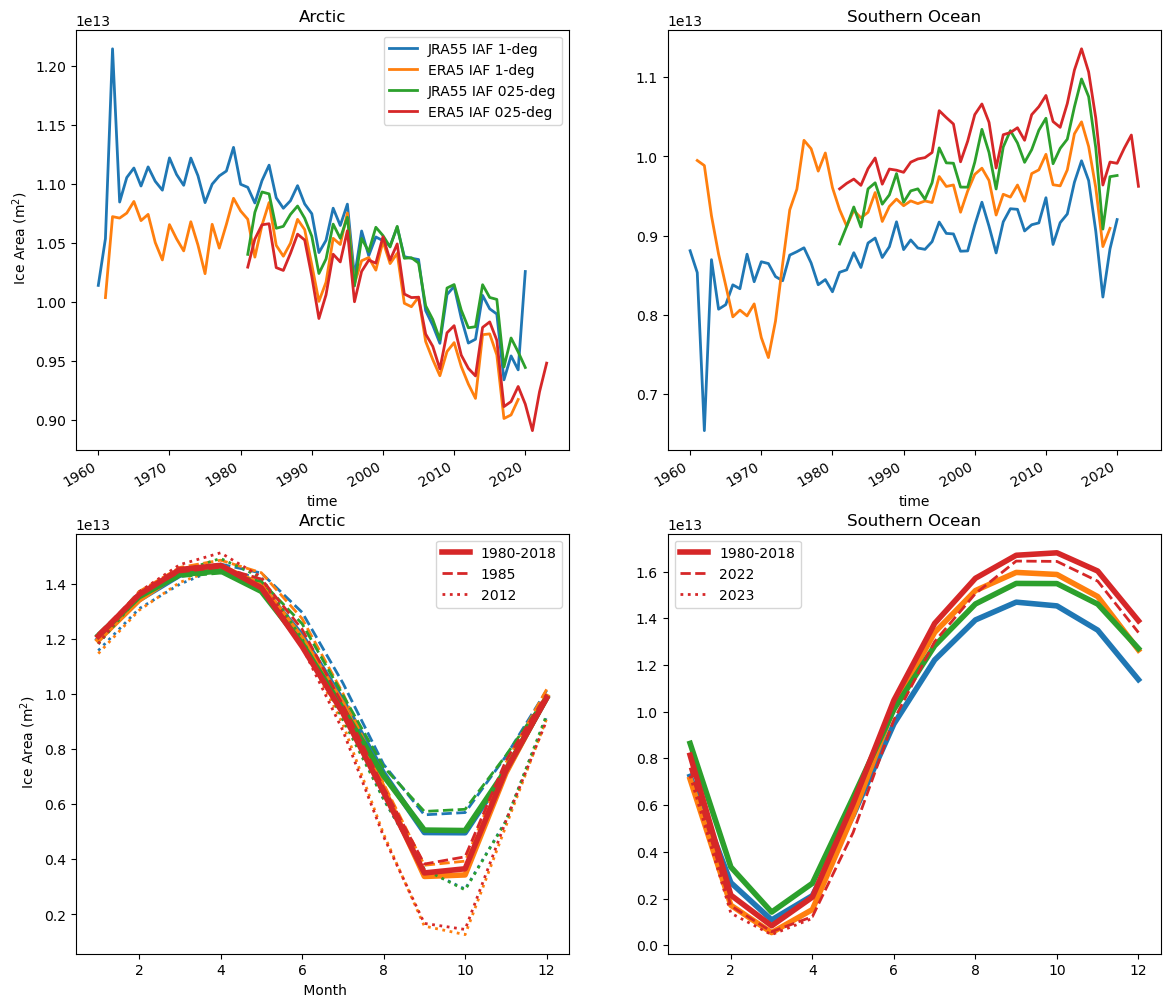

In [6]:
variable='aice_m'
fig,axes = plt.subplots(2,2,figsize=(14,12))
for ekey in runs.keys():
    print(ekey)
    
    lt = sorted(glob.glob(runs[ekey]['base'] + '/output***/ice/OUTPUT/iceh.*.nc'))
    lt = [item for item in lt if 'daily' not in item]
    ds = xr.open_mfdataset(lt, concat_dim="time", combine="nested",
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True)
    var = ds['aice_m']
    area_t = xr.open_dataset(runs[ekey]['base'] + '/output000/ocean/ocean-2d-area_t.nc')['area_t']
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    
    #NH_area.plot(ax=axes[0],label=ekey,color=runs[ekey]['color'])
    #SH_area.plot(ax=axes[1],label=ekey,color=runs[ekey]['color'])
    NH_area.resample(time='Y').mean().isel(time=slice(0,-1)).plot(ax=axes[0][0],color=runs[ekey]['color'],linewidth=2.,label=ekey)
    SH_area.resample(time='Y').mean().isel(time=slice(0,-1)).plot(ax=axes[0][1],color=runs[ekey]['color'],linewidth=2.)

    NH_all = NH_area.sel(time=slice('1980','2018')).groupby('time.month').mean()
    SH_all = SH_area.sel(time=slice('1980','2018')).groupby('time.month').mean()
    if (ekey == 'ERA5 IAF 025-deg'):
        axes[1][0].plot(np.arange(1,13),NH_all.values,color=runs[ekey]['color'],linewidth=4.,label='1980-2018')
        axes[1][1].plot(np.arange(1,13),SH_all.values,color=runs[ekey]['color'],linewidth=4.,label='1980-2018')
    else:
        axes[1][0].plot(np.arange(1,13),NH_all.values,color=runs[ekey]['color'],linewidth=4.)
        axes[1][1].plot(np.arange(1,13),SH_all.values,color=runs[ekey]['color'],linewidth=4.)
    lstys = ['--',':','-.']
    lwids = [1,2,3]
    for i,year in enumerate([1985,2012]):
        NH_sc = NH_area.sel(time=slice(str(year) + '-01-01',str(year) + '-12-31'))
        if (len(NH_sc) != 0):
            if (ekey == 'ERA5 IAF 025-deg'):
                axes[1][0].plot(np.arange(1,len(NH_sc)+1),NH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i],label=str(year))
            else:
                axes[1][0].plot(np.arange(1,len(NH_sc)+1),NH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i])
        else:
            pass
    for i,year in enumerate([2022,2023]):
        SH_sc = SH_area.sel(time=slice(str(year) + '-01-01',str(year) + '-12-31'))
        if (len(SH_sc) != 0):
            if (ekey == 'ERA5 IAF 025-deg'):
                axes[1][1].plot(np.arange(1,len(SH_sc)+1),SH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i],label=str(year))
            else:
                axes[1][1].plot(np.arange(1,len(SH_sc)+1),SH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i])
        else:
            pass
        
axes[0][0].set_ylabel(' Ice Area (m$^2$)')
axes[0][0].legend()
axes[0][0].set_title('Arctic')
axes[0][1].set_title('Southern Ocean')
axes[1][0].set_ylabel(' Ice Area (m$^2$)')
axes[1][0].set_xlabel(' Month')
axes[1][0].legend()
axes[1][1].legend()
axes[1][0].set_title('Arctic')
axes[1][1].set_title('Southern Ocean')